In [11]:
import numpy as np
import random

num_entities = 100
num_validators = 50000
num_slots = 30000
fixed_reward = 0.025
sigma_mev_reward = 1
split_threshold = 32

def generate_distribution(desired_median, num_points=210_000, max_values=[692, 550, 198], num_points_upper=35_000, lower_range=(0, 0.13)):
    # Calculate the mean based on the desired median
    mu = np.log(desired_median)

    # Generate a lognormal distribution with a long tail
    dist = np.random.lognormal(mean=mu, sigma=1.5, size=num_points)

    # Truncate the distribution between 0 and 0.13 ETH
    truncated_dist = dist[(dist >= lower_range[0]) & (dist <= lower_range[1])]

    # Calculate the number of data points we need to add to the upper part
    num_points_to_add = num_points - len(truncated_dist)

    # Add the remaining data points with specific maximum values
    additional_points = []
    for max_value in max_values:
        points = np.linspace(lower_range[1], max_value, num_points_to_add // len(max_values))
        additional_points.extend(points)

    # Combine the truncated lower part and the additional upper part
    final_dist = np.concatenate([truncated_dist, additional_points])

    return final_dist

# Define the MEV reward distributions for each entity
average_builder_median = 0.065
best_builder_median = 0.13
good_builder_median = average_builder_median * (1 + sigma_mev_reward)

entity_mev_distributions = [
    generate_distribution(best_builder_median),
    generate_distribution(good_builder_median),
    generate_distribution(good_builder_median)
] + [generate_distribution(average_builder_median) for _ in range(num_entities - 3)]

# Create validator_entity_mapping and initialize rewards
validator_entity_mapping = [i % num_entities for i in range(num_validators)]
validator_rewards = np.zeros(num_validators)
entity_rewards = np.zeros(num_entities)

# Create lists of validators per entity
validators_per_entity = [[] for _ in range(num_entities)]
for validator_idx, entity in enumerate(validator_entity_mapping):
    validators_per_entity[entity].append(validator_idx)

# Run the simulation
for i in range(num_slots):

    if i%100 == 0:
        print(i)

    # Select a random validator
    chosen_validator = random.randrange(num_validators)

    # Assign rewards
    block_reward = fixed_reward
    chosen_entity = validator_entity_mapping[chosen_validator]
    mev_reward_distribution = entity_mev_distributions[chosen_entity]
    mev_reward = np.random.choice(mev_reward_distribution)
    total_reward = block_reward + mev_reward

    validator_rewards[chosen_validator] += total_reward
    entity_rewards[chosen_entity] += total_reward

    # Check if we need to spawn a new validator for any entity
    for entity_idx in range(num_entities):
        if entity_rewards[entity_idx] >= split_threshold:
            # Spawn a new validator for this entity
            num_validators += 1
            validator_entity_mapping.append(entity_idx)
            validator_rewards = np.append(validator_rewards, 0)
            validators_per_entity[entity_idx].append(num_validators - 1)

            # Deduct the rewards used to spawn the new validator from the existing validators
            to_deduct = split_threshold
            for validator_idx in validators_per_entity[entity_idx]:
                if to_deduct > 0:
                    deduct_amount = min(validator_rewards[validator_idx], to_deduct)
                    validator_rewards[validator_idx] -= deduct_amount
                    entity_rewards[entity_idx] -= deduct_amount
                    to_deduct -= deduct_amount

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
print("Top 20 validator stakes:")
for idx in sorted_indices[-20:]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

print("Bottom 20 validator stakes:")
for idx in sorted_indices[:20]:
    print(f"Validator {idx}: {validator_rewards[idx]}")

# Count validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the total value each entity controls
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

# Print the results
print("Validators per entity:")
for i in range(num_entities):
    print(f"Entity {i}: {validators_count_per_entity[i]}")

print("Total value each entity controls:")
for i in range(num_entities):
    print(f"Entity {i}: {entity_values[i]}")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18


Summary Statistics:
Number of validators: 124755
Average stake: 0.013437450277418276
Median stake: 0.0
Standard deviation of stake: 0.5855498803664329

Top 20 validator stakes:
  Validator     Stake
-----------  --------
       6531  146.733
      21177   34.7238
      85263   29.4214
     122861   28.523
      80424   28.283
      93980   27.4794
      35932   26.9801
      95078   26.8105
      83206   24.5139
       1084   22.5772
      20550   22.246
       9620   22.1454
      43355   21.6621
     103380   21.5863
      89814   21.4961
       1861   20.8624
      84857   20.1361
      44651   19.9437
     118311   19.6054
     118131   19.5672

Bottom 20 validator stakes:
  Validator    Stake
-----------  -------
          0        0
      82866        0
      82865        0
      82864        0
      82863        0
      82862        0
      82861        0
      82860        0
      82859        0
      82858        0
      82857        0
      82856        0
      82855        

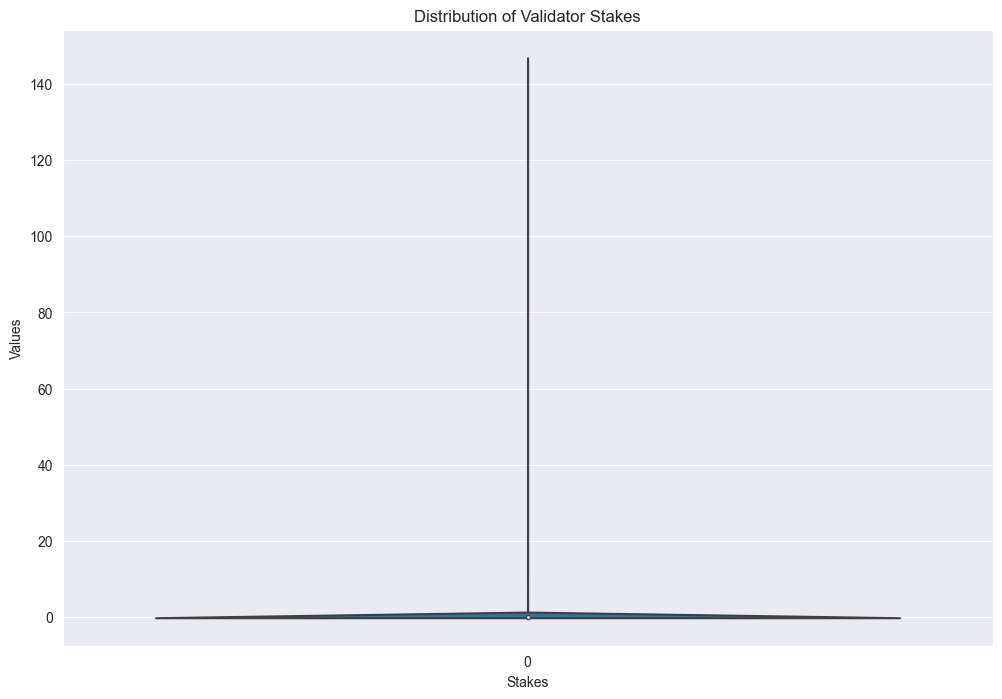

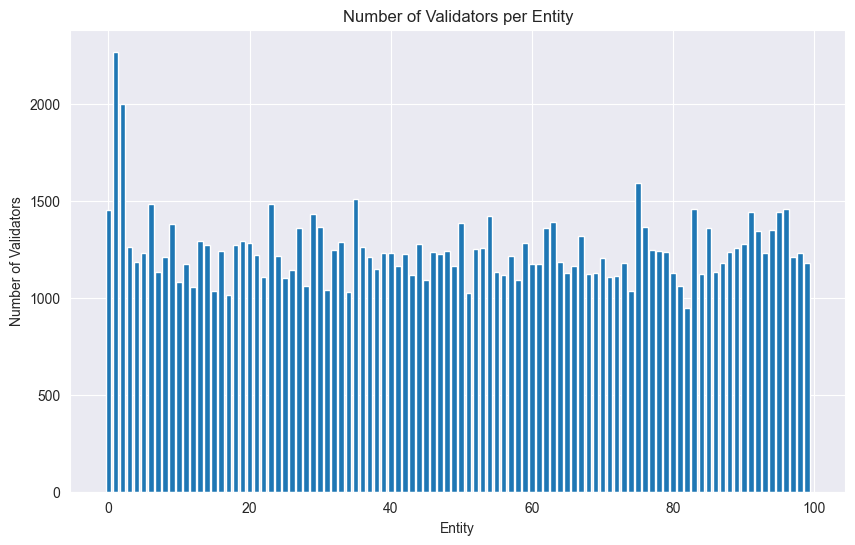

In [16]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np

# Calculate summary statistics
num_validators = len(validator_rewards)
average_stake = np.mean(validator_rewards)
median_stake = np.median(validator_rewards)
std_dev_stake = np.std(validator_rewards)

summary_statistics = {
    "Number of validators": num_validators,
    "Average stake": average_stake,
    "Median stake": median_stake,
    "Standard deviation of stake": std_dev_stake,
}

# Print the summary statistics
print("\nSummary Statistics:")
for k, v in summary_statistics.items():
    print(f"{k}: {v}")

# Print the top and bottom 20 validator stakes
sorted_indices = np.argsort(validator_rewards)
top_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[-20:]][::-1]
bottom_stakes = [(idx, validator_rewards[idx]) for idx in sorted_indices[:20]]

print("\nTop 20 validator stakes:")
print(tabulate(top_stakes, headers=["Validator", "Stake"]))

print("\nBottom 20 validator stakes:")
print(tabulate(bottom_stakes, headers=["Validator", "Stake"]))

# Calculate entity statistics
validators_count_per_entity = [len(validators) for validators in validators_per_entity]
entity_values = np.array(validators_count_per_entity) * 32 + entity_rewards

entity_statistics = list(zip(range(num_entities), validators_count_per_entity, entity_values))

# Print the entity statistics
print("\nEntity Statistics:")
print(tabulate(entity_statistics, headers=["Entity", "Validators", "Total Value"]))

import seaborn as sns

plt.figure(figsize=(12, 8))
sns.violinplot(validator_rewards)
plt.title('Distribution of Validator Stakes')
plt.xlabel('Stakes')
plt.ylabel('Values')
plt.show()

# Plot the number of validators per entity
plt.figure(figsize=(10, 6))
plt.bar(range(num_entities), validators_count_per_entity)
plt.title('Number of Validators per Entity')
plt.xlabel('Entity')
plt.ylabel('Number of Validators')
plt.show()

In [15]:
# Calculate the number of validators per entity
validators_count_per_entity = [len(validators) for validators in validators_per_entity]

# Calculate the stats
min_val = np.min(validators_count_per_entity)
max_val = np.max(validators_count_per_entity)
median_val = np.median(validators_count_per_entity)
avg_val = np.mean(validators_count_per_entity)

# Print the stats
print("Number of validators per entity:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Median: {median_val}")
print(f"Average: {avg_val}")

Number of validators per entity:
Minimum: 945
Maximum: 2269
Median: 1229.5
Average: 1247.55
